In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import polyphase
from itertools import product
import polyphase
import matplotlib.pyplot as plt

In [3]:
delta_d = np.linspace(15,20, num=5)
delta_p = np.linspace(1,10, num=5)
delta_h = np.linspace(1,10, num=5)
solvents = list(product(delta_d, delta_p, delta_h))
solvents = np.asarray(solvents)
assert solvents.shape[0]==125, "Number of solvents are not 125"

In [4]:
SM = [['IDIC',18.7,7.2,4.5,1011,1]]
polymers = [['PTB7-Th',18.56,2.3,3.21,5e4,1]]

SM_df = pd.DataFrame.from_records(SM, columns=['name','dD','dP','dH','MW', 'rho'])
polymer_df = pd.DataFrame.from_records(polymers, columns=['name','dD','dP','dH','MW', 'rho'])
solvents_df = pd.DataFrame.from_records(np.hstack((np.arange(len(solvents)).reshape(-1,1), solvents)),
                                        columns=['name','dD','dP','dH'])

In [5]:
def get_system(indx):
    delta_solvent = solvents_df.loc[indx[0],['dD','dP','dH']].tolist()
    M_solv = 1
    MVol = 100

    delta_sm = SM_df.loc[indx[1],['dD','dP','dH']].tolist()
    M_sm = (SM_df.loc[indx[1],'MW']/SM_df.loc[indx[1],'rho'])*(1/MVol)
    
    delta_polymer = polymer_df.loc[indx[2],['dD','dP','dH']].tolist()
    M_polymer = (polymer_df.loc[indx[2],'MW']/polymer_df.loc[indx[2],'rho'])*(1/MVol)
    
    M = [M_polymer, M_sm, M_solv]
    chi,_ = polyphase.get_chi_vector([delta_polymer,delta_sm,delta_solvent], MVol, 2)
 
    out = [polymer_df.loc[indx[2],'name'],SM_df.loc[indx[1],'name'],solvents_df.loc[indx[0],'name'],
           chi[0], chi[1], chi[2], M,
           delta_polymer, delta_sm,  delta_solvent
    ]   
    return out

axes = [np.arange(0,len(solvents_df)),np.arange(0,len(SM_df)),np.arange(0,len(polymer_df))]
hte_df = pd.DataFrame(get_system(i) for i in product(*axes))
hte_df.columns =['polymer', 'SM','solvent','chi12','chi13','chi23',
                 'dop','delta_polymer','delta_SM','delta_solvent'] 
print('Total of {} systems'.format(len(hte_df)))
hte_df.head()

Total of 125 systems


,polymer,SM,solvent,chi12,chi13,chi23,dop,delta_polymer,delta_SM,delta_solvent
0,PTB7-Th,IDIC,0.0,1.370081,1.111655,2.921045,"[500.0, 10.11, 1]","[18.56, 2.3, 3.21]","[18.7, 7.2, 4.5]","[15.0, 1.0, 1.0]"
1,PTB7-Th,IDIC,1.0,1.370081,0.915912,2.492574,"[500.0, 10.11, 1]","[18.56, 2.3, 3.21]","[18.7, 7.2, 4.5]","[15.0, 1.0, 3.25]"
2,PTB7-Th,IDIC,2.0,1.370081,1.126088,2.470023,"[500.0, 10.11, 1]","[18.56, 2.3, 3.21]","[18.7, 7.2, 4.5]","[15.0, 1.0, 5.5]"
3,PTB7-Th,IDIC,3.0,1.370081,1.742183,2.853392,"[500.0, 10.11, 1]","[18.56, 2.3, 3.21]","[18.7, 7.2, 4.5]","[15.0, 1.0, 7.75]"
4,PTB7-Th,IDIC,4.0,1.370081,2.764198,3.642679,"[500.0, 10.11, 1]","[18.56, 2.3, 3.21]","[18.7, 7.2, 4.5]","[15.0, 1.0, 10.0]"


## Create a chi-space grid


In [6]:
NUM_PER_DIMENSION = 2
chi12 = np.linspace(1.3,1.44, num=NUM_PER_DIMENSION)
chi13 = np.linspace(0.2,5, num=NUM_PER_DIMENSION)
chi23 = np.linspace(0.2,5, num=NUM_PER_DIMENSION)
chispace = list(product(chi12, chi13, chi23))
chispace = np.asarray(chispace)
df = pd.DataFrame(chispace, columns=['chi12', 'chi13', 'chi23'])

In [7]:
import os, shutil
from collections import Counter

dirname = '../figures/chispace/testcase'
if os.path.exists(dirname):
    shutil.rmtree(dirname)    
os.makedirs(dirname)


num_simplices = []
for i, chi in df.iterrows():
    M = [10,10,1]
    f = lambda x: polyphase.flory_huggins(x , M, chi, logapprox=True)
    engine = polyphase.PHASE(f, 200,3)
    engine.compute(use_parallel=False)
    phaselabels = engine.num_comps 
    twophase = np.sum(np.asarray(phaselabels)==2)
    onephase = np.sum(np.asarray(phaselabels)==1)
    threephase = np.sum(np.asarray(phaselabels)==3)
    num_simplices.append([onephase, twophase, threephase])
    
    polyphase.plot_mpltern(engine.grid, engine.simplices, engine.num_comps)
    plt.savefig(dirname+'{}.png'.format(i), bbox_inches='tight', dpi=300)
    plt.close()

Computation took 10.69s
Computation took 7.71s
Computation took 7.72s
Computation took 7.20s
Computation took 10.15s
Computation took 7.68s
Computation took 7.80s
Computation took 7.21s


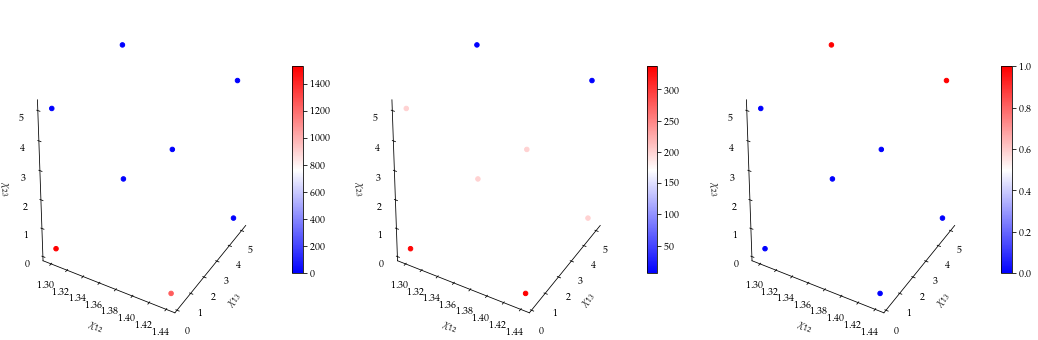

In [33]:
fig, axs = plt.subplots(1,3, figsize=(3*6,6),subplot_kw={'projection':'3d'})
cvalues = np.asarray(num_simplices)
x = df.to_numpy()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

for i,ax in enumerate(axs):
    path = ax.scatter(x[:,0], x[:,1], x[:,2],c=cvalues[:,i],
                      alpha=1.0, cmap='bwr')
    fig.colorbar(path, pad=0.05, ax = ax, fraction=0.035)
    
    ax.set_xlabel(r'$\chi_{12}$')
    ax.set_ylabel(r'$\chi_{13}$')
    ax.set_zlabel(r'$\chi_{23}$')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)
    ax.zaxis._axinfo['juggled'] = (1,2,0)
    ax.tick_params(axis="y",direction="out")
    ax.tick_params(axis="x",direction="out")
    ax.tick_params(axis="z",direction="out")
    
plt.show()

## Analyze HTE data

In [ ]:
# Can we infer anything about where the test fails interms of solubility parameters?
import glob
import re

all_figs = glob.glob('../figures/artificial/*.png')
test_figs = glob.glob('../figures/artificial/test_*.png')
pd_figs = list(set(all_figs).difference(set(test_figs)))

def string_to_dict(string, pattern):
    # from : https://stackoverflow.com/a/36838374
    regex = re.sub(r'{(.+?)}', r'(?P<_\1>.+)', pattern)
    values = list(re.search(regex, string).groups())
    keys = re.findall(r'{(.+?)}', pattern)
    _dict = dict(zip(keys, values))
    return _dict

pattern = '../figures/artificial/{label}_{num_fail}_{total}_{solvent}_{polymer}_{sm}.png'
labels = np.zeros(len(pd_figs))
for fig in pd_figs:
    out = string_to_dict(fig, pattern)
    if out['label']=='True':
        labels[int(out['solvent'])]=1

plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize=(6*1.6,6))
#x = hte_df['delta_solvent'].to_numpy()
x = hte_df[['chi12','chi13','chi23']].to_numpy()
x = np.stack(x, axis=0)
phase_colors = ['r', 'g', 'b']
cmap = colors.ListedColormap(phase_colors)
path = ax.scatter(x[:,0], x[:,1], x[:,2], c=labels, cmap=cmap)
boundaries = np.linspace(1, 3, 3)
norm = colors.BoundaryNorm(boundaries, cmap.N)
mappable = ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(mappable, shrink=0.5, aspect=5, ticks=[1.5, 2.5], ax=ax)
cbar.ax.set_yticklabels(['Failed', 'Passed'])

# sm_solubs = hte_df['delta_SM'][0]
# ax.scatter(sm_solubs[0], sm_solubs[1], sm_solubs[2], marker='*',color='magenta', s=100, label='SM')
# poly_solubs = hte_df['delta_polymer'][0]
# ax.scatter(poly_solubs[0], poly_solubs[1], poly_solubs[2], marker='*',color='k', s=100, label='Polymer')
# ax.legend()
# ax.set_xlabel(r'$\delta_D$')
# ax.set_ylabel(r'$\delta_P$')
# ax.set_zlabel(r'$\delta_H$')
ax.set_xlabel(r'$\chi_{12}$')
ax.set_ylabel(r'$\chi_{13}$')
ax.set_zlabel(r'$\chi_{23}$')
plt.show()